# Test evaluation subsystem for gst-mprtp

All of the test, which has the snd\_ and rcv\_ packetlogs and statlogs along with the veth logs evaluable. You need to define the necessary definitions found in the second and third cell and then in the configuration section you need to run the evaluate measurements process by the appropriate configuration parameters.


In [1]:
# from shutil import copyfile
import os.path

def get_packetlog_columns():
    return [ 'extended_seq',
             'tracked_seq',
             'state',
             'tracked_ntp',
             'marker',
             'header_size',
             'payload_size',
             'timestamp',
             'payload_type',
             'played_out'];


def get_delta_packetlog_columns():
    return ["owd",
            "BiF",
            "playout_delay"];

def get_statslog_columns():
    return [ 'rcved_tot_packets',
             'rcved_tot_bytes',
             'rcved_acc_bytes',
             'rcved_acc_packets',                             

             'lost_tot_packets',
             'lost_tot_bytes',
             'lost_acc_bytes',
             'lost_acc_packets',

             'discarded_tot_packets',
             'discarded_tot_bytes',
             'discarded_acc_bytes',
             'discarded_acc_packets',

             'corrupted_tot_packets',
             'corrupted_tot_bytes',
             'corrupted_acc_bytes',
             'corrupted_acc_packets',

             'repaired_tot_packets',
             'repaired_tot_bytes',
             'repaired_acc_bytes',
             'repaired_acc_packets',

             'fec_tot_packets',
             'fec_tot_bytes',
             'fec_acc_bytes',
             'fec_acc_packets',
            ];
def get_veth_columns():
    return ["tcp_bytes",
            "tcp_packets",
            "tcp_flowsnum",
            "bw_forward", 
            "bw_backward"];

def get_statlog_columns():
    return [ ];

def csv_append(touched, resultfile, obj):
    if(resultfile in touched):
        #print(resultfile + " is already touched")
        ;
    else:
#         print(resultfile + " is removed")
        !rm $resultfile
        touched[resultfile] = True
        
    if(os.path.isfile(resultfile) == False) : 
        with open(resultfile, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(obj.keys())

    # print("------ Obj to save to " + resultfile + "------")
    with open(resultfile, 'a') as f:
        dict_writer = csv.DictWriter(f, obj.keys(), "")
        dict_writer.writerow(obj)


In [2]:
from shutil import copyfile
import os.path
import pandas as pd
import datetime

#Make owd_statlogs
def make_merged_packetlogs(snd_packetlogs, rcv_packetlogs, merged_packetlogs_path):
    packetlog_columns     = get_packetlog_columns()
    snd_packets = pd.read_csv(snd_packetlogs, names=packetlog_columns)
    rcv_packets = pd.read_csv(rcv_packetlogs, names=packetlog_columns)
    
    result = pd.merge(snd_packets, rcv_packets, on='extended_seq', \
                           suffixes=['_snd','_rcv'])

    result.to_csv(merged_packetlogs_path, sep=',')
    
    #Make owd_statlogs
def make_path_statlogs(veth_logfile, 
#                        targets_logfile,
                       snd_statlogfile, 
                       rcv_statlogfile,
                       delta_packetlogfile, 
                       result_filepath,
                       bytefactor):
    
    statlog_columns     = get_statslog_columns()
    
    delta_columns = get_delta_packetlog_columns()
   
    #targets_stats = pd.read_csv(targets_logfile,     names=["target"])
    veth_stats    = pd.read_csv(veth_logfile,        names=get_veth_columns())
    snd_stats     = pd.read_csv(snd_statlogfile,     names=statlog_columns)
    rcv_stats     = pd.read_csv(rcv_statlogfile,     names=statlog_columns)
    packet_dstats = pd.read_csv(delta_packetlogfile, names=delta_columns)
    
    sending_rates = snd_stats.apply(lambda record: record['rcved_acc_packets'] * bytefactor + 
                                    record['rcved_acc_bytes'], axis=1)
    # sending_rates = snd_stats.apply(lambda record: record['rcved_acc_bytes'], axis=1)
    
    fec_rates     = snd_stats.apply(lambda record: record['fec_acc_packets'] * 40 + 
                                    record['fec_acc_bytes'], axis=1)
    
    ffre          = rcv_stats.apply(lambda record:  
                                    record['repaired_acc_packets'] / (record['lost_acc_packets']) if 0 < record['lost_acc_packets'] else 0, axis=1)
    
    #print(rcv_stats['lost_acc_packets'])
    #print(rcv_stats['repaired_acc_packets'])
    #print(packet_dstats);
    result = pd.concat([veth_stats["bw_forward"], 
                        veth_stats["bw_backward"], 
                        sending_rates,
                        fec_rates,
                        packet_dstats['owd'],
                        packet_dstats['BiF'],
                        ffre,
#                         targets_stats["target"],
                        packet_dstats['playout_delay'],
                        rcv_stats["lost_acc_packets"],
                        rcv_stats["repaired_acc_packets"],
                        veth_stats["tcp_flowsnum"],
                        veth_stats["tcp_bytes"],
                        veth_stats["tcp_packets"],                        
                       ], 
                       axis=1)
#    print(result)
    result.to_csv(result_filepath, sep=',')



In [3]:
from shutil import copyfile
from collections import OrderedDict
import os.path
import pandas as pd
import datetime
import numpy
import collections

def evaluate_statslog(snd_statslog_file, 
                      snd_packetlogs_file,
                      rcv_statslog_file, 
                      rcv_packetlogs_file, 
                      veth_logfile, 
                      dpck_logfile,
                      sampling_num, 
                      algorithm,
                      total_flownum,
                      bytefactor):
    
    packetlog_columns = get_packetlog_columns()
    statlog_table     = pd.read_csv(rcv_statslog_file, names=get_statslog_columns())
    snd_statlog_table = pd.read_csv(snd_statslog_file, names=get_statslog_columns())    
    
    veth_table        = pd.read_csv(veth_logfile,  names=get_veth_columns())
        
    statlog_table     = statlog_table.join(snd_statlog_table, rsuffix = '_snd', lsuffix = '_rcv')
    statlog_table     = statlog_table.join(veth_table)

    dpcklog_table     = pd.read_csv(dpck_logfile,  names=get_delta_packetlog_columns()).head(sampling_num + 1).tail(sampling_num)
    goodput_helper    = pd.Series(((statlog_table["rcved_acc_bytes_rcv"] - statlog_table["discarded_acc_bytes_rcv"]) + 
                                 (statlog_table["rcved_acc_packets_rcv"] - statlog_table["discarded_acc_packets_rcv"]) * bytefactor ) / 125)
    fecrate_helper   = pd.Series(((statlog_table["fec_acc_bytes_snd"]) + 
                                  (statlog_table["fec_acc_packets_snd"] * 40)) / 125)
    
    owdmean_helper    = pd.Series(dpcklog_table["owd"] / 1000)

    #shaping
    available_sampling_num = len(statlog_table["rcved_acc_packets_rcv"])
    if(available_sampling_num < sampling_num) : 
        print("Required sampling number is " + str(sampling_num) + 
              " available: " + str(available_sampling_num) + " at " + rcv_statslog_file)
        return
    
    # print("Required sampling num is " + str(sampling_num) + " : " + str(len(statlog_table["rcved_acc_packets"])))
    
    statlog_table     = statlog_table.head(sampling_num + 1).tail(sampling_num)
    veth_table        = veth_table.head(sampling_num + 1).tail(sampling_num)
    dpcklog_table     = dpcklog_table.head(sampling_num + 1).tail(sampling_num)
    goodput_helper    = goodput_helper.head(sampling_num + 1).tail(sampling_num)
    fecrate_helper    = fecrate_helper.head(sampling_num + 1).tail(sampling_num)
    
    index = sampling_num - 1
    rcved_packets     = statlog_table.iloc[index]["rcved_tot_packets_rcv"]
    repaired_packets  = statlog_table.iloc[index]["repaired_tot_packets_rcv"]
    rcved_packets     = statlog_table.iloc[index]["rcved_tot_packets_rcv"]
    rcved_bytes       = statlog_table.iloc[index]["rcved_tot_bytes_rcv"]
    discarded_packets = statlog_table.iloc[index]["discarded_tot_packets_rcv"]
    discarded_bytes   = statlog_table.iloc[index]["discarded_tot_bytes_rcv"]
    lost_packets      = statlog_table.iloc[index]["lost_tot_packets_rcv"]
    received_packets  = int(statlog_table.iloc[index]["rcved_tot_packets_rcv"])
    
    lost_rate         = float(lost_packets) / float(received_packets + lost_packets) if 0 < lost_packets else 0.
    lost_rate         = round(lost_rate*100,2)

    #print("received_packets: " + str(received_packets))
    packetlogs_table  = pd.read_csv(rcv_packetlogs_file, names=packetlog_columns).head(received_packets + 1).tail(received_packets)
    

    frame_is_lost   = False
    lost_frames     = 0
    received_frames = 0    
    last_timestamp  = 0;
    
    for index, row in packetlogs_table.iterrows():
        if(row["timestamp"] != 0):
            last_timestamp = row["timestamp"]
            break

    for index, row in packetlogs_table.iterrows():
        if(row["timestamp"] == 0 or row["state"] != 1):
            frame_is_lost = True;
            continue;
        if(row["timestamp"] != last_timestamp):
            last_timestamp = row["timestamp"]
            if(frame_is_lost):
                lost_frames += 1
            else: 
                received_frames += 1
            frame_is_lost = False;
      
    repaired_rate = 0.
    ffre          = 0.
    tfs_list      = []
    tfs           = 0

    #algorithm cut by fractal and scream
    last_tot_fec_packets       = 0 
    protected_but_lost         = 0
    recovered                  = 0
    not_protected_and_lost     = 0
    last_row                   = 0
    tot_fec_packets = collections.deque()
    tot_fec_packets_count      = 0
    init = False
    for index, row in statlog_table.iterrows():
        #calculate ffre
        tot_fec_packets.append(row["fec_tot_packets_snd"])
        tot_fec_packets_count += 1
        if(init == False):
            init = True
            last_row = row
            continue

        if(2 < tot_fec_packets_count):
            last_tot_fec_packets   = tot_fec_packets.popleft()
            tot_fec_packets_count -= 1

        last_known_total_lost      = row["lost_tot_packets_rcv"]
        last_known_total_recovered = row["repaired_tot_packets_rcv"]
        drecovered         = row["repaired_tot_packets_rcv"] - last_row["repaired_tot_packets_rcv"]
        dlost              = row["lost_tot_packets_rcv"] - last_row["lost_tot_packets_rcv"] 
        recovered          += drecovered 
        if(row["fec_tot_packets_snd"] != last_tot_fec_packets):
            protected_but_lost += dlost - drecovered if drecovered <= dlost else 0
        else:
            not_protected_and_lost += dlost - drecovered if drecovered <= dlost else 0
        last_row = row
        
        #calculate tfs
        if(row["tcp_flowsnum"] == 0):
            actual_tfs = 0
            continue
        elif(row["rcved_acc_bytes_snd"] == 0):
            print("Warning! RTP Sent bytes are 0")
            actual_tfs = 0
        else:
            tcp_throughput = float(row["tcp_bytes"] + row["tcp_packets"] * 20)            
            actual_tfs  =  tcp_throughput / float(row["tcp_flowsnum"])
            actual_tfs /= float(tcp_throughput + row["rcved_acc_bytes_snd"] + row["rcved_acc_packets_snd"] * bytefactor) / float(row["tcp_flowsnum"] + 1)
        tfs_list.append(actual_tfs)
            
    #print("protected_but_lost: " + str(protected_but_lost) + " lost" + str(not_protected_and_lost) + " recovered: " + str(recovered))
    #print("TFS: " + str(numpy.array(tfs).mean()))
    if(0 < protected_but_lost):
        ffre = float(100 * recovered) / float(protected_but_lost + recovered)
    if(tfs_list):
        tfs = numpy.array(tfs_list).mean() * 100.0
        
    if(0 < lost_packets):
        repaired_rate = float(repaired_packets) / float(repaired_packets + lost_packets)
    repaired_rate = round(repaired_rate*100,2)
    
    lost_frame_rate = 0;
    if(0 < received_frames):
        lost_frame_rate = float(lost_frames) / float(lost_frames + received_frames)
    lost_frame_rate = round(lost_frame_rate*100,2)
    
    #Handy if you want to identify the measurement not by count but by property
    #print("The goodput mean is: " + str(round(goodput_helper.mean(), 2)) )
    return OrderedDict([
        #('repaired_packets_num',    repaired_packets),
        #('repaired_rate',           repaired_rate),
        ('fecrate_mean',            fecrate_helper.mean()),
        ('fecrate_std',             fecrate_helper.std()), 
        ('lost_packet_rate',        lost_rate), 
        ('goodput_mean',            round(goodput_helper.mean(), 2)),
        ('goodput_std',             round(goodput_helper.std(), 2)),
        #('lost_packets_num',        lost_packets),
        ('ffre',                    ffre), 
        ('rcved_packets_num',       rcved_packets),
        ('lost_frames_num',         lost_frames),
        ('lost_frame_rate',         lost_frame_rate),
        ('received_frames',         received_frames),
        ('owd mean',                owdmean_helper.mean()),
        ('owd std',                 owdmean_helper.std()),
        #('received_bytes',          rcved_bytes), 
        ('tfs',                     tfs)
    ]);

def evaluate_videofiles(original, processed, width, height, framesnum, targetname):
    psnr_file   = targetname + "_psnr.csv"
    ssim_file   = targetname + "_ssim.csv"
    msssim_file = targetname + "_msssim.csv"
    vifp_file   = targetname + "_vifp.csv"
    columns     = ["frame","value"]
    
    print("Evaluating Video")
    print("Source: " + original +" Processed: " + processed + " W: " + str(width) + " H: " + str(height) + " psnr: " + psnr_file)
    print("Framesnum: " + str(framesnum))
    
    #!vqmt $original $processed $height $width $framesnum 1 $targetname PSNR SSIM MSSSIM VIFP
    !vqmt $original $processed $height $width $framesnum 1 $targetname PSNR 
    
    psnr    = pd.Series(pd.read_csv(psnr_file,    names=columns).head(-1).tail(-1).astype('float')["value"])
    #ssim    = pd.Series(pd.read_csv(ssim_file,    names=columns).head(-1).tail(-1).astype('float')["value"])
    #msssim  = pd.Series(pd.read_csv(msssim_file,  names=columns).head(-1).tail(-1).astype('float')["value"])
    #vifp    = pd.Series(pd.read_csv(vifp_file,    names=columns).head(-1).tail(-1).astype('float')["value"])
    
    return {
        "psnr_mean": psnr.mean(),
        "psnr_std":  psnr.std(),
        #"ssim_mean": ssim.mean(),
        #"ssim_std":  ssim.std(),
        #"msssim_mean": msssim.mean(),
        #"msssim_std":  msssim.std(),
        #"vifp_mean": vifp.mean(),
        #"vifp_std":  vifp.std(),
        };
    
    

In [4]:
#!cd ../../temp; ls #The directory where the logfiles are
base_path       = "../../"
plot_path       = "../gnuplots"
temp_path       = base_path + "/temp" 


In [7]:
import os
import csv
import shutil

def process_measurements(config, fails): 
    
    test_path         = config['base_path'] + "scripts/saves/" + config['test'] + "/"
    touched           = {}
    flowstat_suffixes = ["","2","3"]
    flowcsv_prefixes  = ["flow1", "flow2", "flow3"]

    viewpdf           = config['base_path'] + "/temp/statlogs.pdf"
    touched = {}
    owd_dict = {'50ms':50000, '100ms':100000, '300ms': 300000, '50x100x150ms': 0}
    
    for dirname, dirnames, filenames in os.walk(test_path):
        for targetdir in dirnames:
            algorithm, count, owd, jitter = targetdir.split('_')
            meas_path = config['base_path'] + "scripts/saves/" + config['test'] + "/" + '_'.join([algorithm, count, owd, jitter])

            #Ignoring some cases if we know that they are ok.
            if('only_algorithm' in config):
                if(config['only_algorithm'] != algorithm):
                    continue
            if('only_owd' in config):
                if(config['only_owd'] != owd):
                    continue
            if('only_count' in config):
                if(config['only_count'] != count):
                    continue

            print("--- Operate in " + meas_path + " ---")

            bandwidth        = meas_path + "/bandwidth.csv"
            veth0_stats      = meas_path + "/veth0_stats.csv"
            rmcat_tmplogs    = meas_path + "/rmcat_tmplogs.csv"
            plotfile         = plot_path + "/" + config['test'] + ".plot"
            outplot          = meas_path + "/" + '_'.join([config['test'],algorithm,owd,jitter]) + ".pdf"
            gnuplot_params   = ""
            bytefactor       = 28 if algorithm == "fractal" else 20

            # print("Bytefactor: " + str(bytefactor))

            for flowcounter in range(0, config['flownum']):

                stat_suffix      = flowstat_suffixes[flowcounter]

                snd_statlogs     = meas_path + "/snd_statlogs"    + stat_suffix + ".csv"
                rcv_statlogs     = meas_path + "/rcv_statlogs"    + stat_suffix + ".csv"
                snd_packetlogs   = meas_path + "/snd_packetlogs"  + stat_suffix + ".csv"
                rcv_packetlogs   = meas_path + "/rcv_packetlogs"  + stat_suffix + ".csv"
                merged_statlogs  = meas_path + "/merged_statlogs" + stat_suffix + ".csv"  
                delta_statlogs   = meas_path + "/delta_statlogs"  + stat_suffix + ".csv"
                rmcat_statlogs   = meas_path + "/rmcat_statlogs"  + stat_suffix + ".csv"
                evalfile         = meas_path + "/evaluation"      + stat_suffix + ".csv"

                gnuplot_params  += "-e statlogs=\'" + rmcat_statlogs + "\' "

                #Made merged statlogs
                try:
                    make_merged_packetlogs(snd_packetlogs, rcv_packetlogs, merged_statlogs)
                    !./../../make_delta_statlogs $merged_statlogs $delta_statlogs > log.txt
                except:
                    fails.append({"algorithm": algorithm, "owd": owd, "jitter":jitter, "count": count});
                    print("ERROR: " + meas_path + " does not have files")
                    continue

                make_path_statlogs(veth0_stats, 
                #              targetsfile, 
                               snd_statlogs, 
                               rcv_statlogs, 
                               delta_statlogs, 
                               rmcat_statlogs,
                               bytefactor)

                !sed '1d' $rmcat_statlogs > $rmcat_tmplogs; mv $rmcat_tmplogs $rmcat_statlogs

                flowcsv_prefix = flowcsv_prefixes[flowcounter]

                eval_result = evaluate_statslog(snd_statlogs,
                                                snd_packetlogs,
                                                rcv_statlogs, 
                                                rcv_packetlogs, 
                                                veth0_stats, 
                                                delta_statlogs, 
                                                config['min_samplingnum'],
                                                algorithm,
                                                config['flownum'],
                                                bytefactor)

                psnr_resultfile = meas_path + "/vqmt_psnr.csv"
                if(os.path.isfile( psnr_resultfile )) : 
                    psnr = pd.Series(pd.read_csv(psnr_resultfile, names=["frame","value"]).head(-1).tail(-1).astype('float')["value"])
                    eval_result["psnr_mean"] = psnr.mean()
                    eval_result["psnr_std"]  = psnr.std()

                resultfile = test_path + '_'.join([flowcsv_prefix, algorithm, owd, jitter]) +".csv"
                try:
                    csv_append(touched, resultfile, eval_result)
                except AttributeError:
                    fails.append({"algorithm": algorithm, "owd": owd, "jitter":jitter, "count": count});
                    print("ERROR: " + meas_path + " does not have the sufficient amount of sampling")
                    continue
            
            path_delay = owd_dict[owd]
            if(config['flownum'] == 1):
                !gnuplot -e "statlogs='$meas_path/rmcat_statlogs.csv'" \
                     -e "output_file='$outplot'" \
                     -e "path_delay='$path_delay'"  \
                     -e "algorithm='$algorithm'" \
                     $plotfile
            elif(config['flownum'] == 2):
                !gnuplot -e "statlogs='$meas_path/rmcat_statlogs.csv'" \
                         -e "statlogs2='$meas_path/rmcat_statlogs2.csv'" \
                         -e "output_file='$outplot'" \
                         -e "path_delay='$path_delay'" \
                        -e "algorithm='$algorithm'" \
                         $plotfile
            elif(config['flownum'] == 3):
                !gnuplot -e "statlogs='$meas_path/rmcat_statlogs.csv'" \
                         -e "statlogs2='$meas_path/rmcat_statlogs2.csv'" \
                         -e "statlogs3='$meas_path/rmcat_statlogs3.csv'" \
                         -e "output_file='$outplot'" \
                        -e "path_delay='$path_delay'" \
                         -e "algorithm='$algorithm'" $plotfile
         
    algorithms = ["fractal", "scream"]
    owds       = ["50ms", "100ms", "300ms","50x100x150ms"]
    jitters    = ["0ms"]

    with open(test_path + "all.csv", 'wb') as csvfile:
        writeCSV = csv.writer(csvfile)
        for alg in algorithms:
            for owd in owds:
                for jitter in jitters:
                    for flowcounter in range(0, config['flownum']):
                        flow_prefix = flowcsv_prefixes[flowcounter]
                        csv_path = test_path + '_'.join([flow_prefix, alg, owd, jitter]) + ".csv"
                        if(os.path.isfile(csv_path) == False):
                            continue

                        #An initiation that a directory for 1 to 10 atuomatically created   
                        #directory = test_path + '_'.join([alg,owd,])
                        #os.path.isdir("bob")
                        
                        start = 0
                        with open(csv_path) as csvfile:
                            readCSV = csv.reader(csvfile, delimiter=',')
                            info = " | ".join(["algorithm: " + alg, 
                                               "owd: "       + owd, 
                                               "jitter: "    + jitter, 
                                               "flow: "      + flow_prefix])
                            writeCSV.writerow([info])
                            for row in readCSV:
                                writeCSV.writerow(row)
                                start+=1
                            for emptyRow in range(start, 11):
                                writeCSV.writerow('')
                            print(info + " processed, " + str(11 - start) + " row is added as empty")
                        
    print("Process for " + config['test'] + " is done")

def onlyplotting(config): 
    test_path         = config['base_path'] + "scripts/saves/" + config['test'] + "/"
    touched           = {}
    flowstat_suffixes = ["","2","3"]
    flowcsv_prefixes  = ["flow1", "flow2", "flow3"]

    viewpdf           = config['base_path'] + "/temp/statlogs.pdf"
    touched = {}
    owd_dict = {'50ms':50000, '100ms':100000, '300ms': 300000, '50x100x150ms': 0}
    
    for dirname, dirnames, filenames in os.walk(test_path):
        for targetdir in dirnames:
            algorithm, count, owd, jitter = targetdir.split('_')
            meas_path = config['base_path'] + "scripts/saves/" + config['test'] + "/" + '_'.join([algorithm, count, owd, jitter])
            
            rmcat_tmplogs    = meas_path + "/rmcat_tmplogs.csv"
            plotfile         = plot_path + "/" + config['test'] + ".plot"
            outplot          = meas_path + "/" + '_'.join([config['test'],algorithm,owd,jitter]) + ".pdf"
            path_delay       = owd_dict[owd]
            
            if(config['flownum'] == 1):
                !gnuplot -e "statlogs='$meas_path/rmcat_statlogs.csv'" \
                     -e "output_file='$outplot'" \
                     -e "path_delay='$path_delay'"  \
                    -e "algorithm='$algorithm'" \
                     $plotfile
            elif(config['flownum'] == 2):
                !gnuplot -e "statlogs='$meas_path/rmcat_statlogs.csv'" \
                         -e "statlogs2='$meas_path/rmcat_statlogs2.csv'" \
                         -e "output_file='$outplot'" \
                         -e "path_delay='$path_delay'" \
                        -e "algorithm='$algorithm'" \
                        $plotfile
            elif(config['flownum'] == 3):
                !gnuplot -e "statlogs='$meas_path/rmcat_statlogs.csv'" \
                         -e "statlogs2='$meas_path/rmcat_statlogs2.csv'" \
                         -e "statlogs3='$meas_path/rmcat_statlogs3.csv'" \
                         -e "output_file='$outplot'" \
                        -e "path_delay='$path_delay'" \
                         -e "algorithm='$algorithm'" \
                         $plotfile
            
            print("Plotting " + meas_path)
            
    

def measurement_repair(failed, src_path, dst_path):
    for dirname, dirnames, filenames in os.walk(src_path):
        for targetdir in dirnames:
            algorithm, count, owd, jitter = targetdir.split('_')
            if(failed['algorithm'] != algorithm or
               failed['owd']       != owd       or
               failed['jitter']    != jitter
              ):
                continue

            meas_dir = '_'.join([algorithm, failed['count'], owd, jitter])
            print("Try to repair " + dst_path + "/" + meas_dir + " from " + src_path + "/" + targetdir)
            !rm $dst_path/$meas_dir/*
            !cp $src_path/$targetdir/* $dst_path/$meas_dir
            #!mv $src_path/$targetdir ../$src_path
            shutil.rmtree(src_path + "/" + targetdir)
            return True
        return False




In [16]:
configs = []

# - - - - - - RMCAT1 Config - - - - - - - - - -
config = {}
config['only_owd']          = "300ms"
config['only_algorithm']    = "fractal"
config['only_count']        = "4"
config['base_path']         = "../../"                       
config['test']              = "rmcat1"
config['flownum']           = 1
config['min_samplingnum']   = 1200
config['repair_path_src']   = "../../measurements/" + config["test"]
config['repair_path_dst']   = config['base_path'] + "scripts/saves/" + config["test"]

# configs.append(config) #<-UNCOMMENT THIS EVALUATE RMCAT1 MEASUREMENTS

# - - - - - - RMCAT2 Config - - - - - - - - - -
config = {}
config['only_owd']          = "100ms"
config['only_algorithm']    = "fractal"
config['only_count']        = "1"
config['base_path']         = "../../"                       
config['test']              = "rmcat2"
config['flownum']           = 2
config['min_samplingnum']   = 1200
config['repair_path_src']   = "../../measurements/" + config["test"]
config['repair_path_dst']   = config['base_path'] + "scripts/saves/" + config["test"]

# configs.append(config) #<-UNCOMMENT THIS EVALUATE RMCAT2 MEASUREMENTS

# - - - - - - RMCAT3 Config - - - - - - - - - -
config = {}
config['only_owd']          = "100ms"
config['only_algorithm']    = "scream"
config['only_count']        = "1"
config['base_path']         = "../../"                       
config['test']              = "rmcat3"
config['flownum']           = 2
config['min_samplingnum']   = 1200
config['repair_path_src']   = "../../measurements/" + config["test"]
config['repair_path_dst']   = config['base_path'] + "scripts/saves/" + config["test"]

# configs.append(config) #<-UNCOMMENT THIS EVALUATE RMCAT3 MEASUREMENTS

# - - - - - - RMCAT4 Config - - - - - - - - - -
config = {}
config['only_owd']          = "100ms"
config['only_algorithm']    = "scream"
config['only_count']        = "9"
config['base_path']         = "../../"                       
config['test']              = "rmcat4"
config['flownum']           = 3
config['min_samplingnum']   = 1200
config['repair_path_src']   = "../../measurements/" + config["test"]
config['repair_path_dst']   = config['base_path'] + "scripts/saves/" + config["test"]

# configs.append(config) #<-UNCOMMENT THIS EVALUATE RMCAT4 MEASUREMENTS

# - - - - - - RMCAT5 Config - - - - - - - - - -
config = {}
config['only_owd']          = "100ms"
config['only_algorithm']    = "scream"
config['only_count']        = "1"
config['base_path']         = "../../"                       
config['test']              = "rmcat5"
config['flownum']           = 3
config['min_samplingnum']   = 2750
config['repair_path_src']   = "../../measurements/" + config["test"]
config['repair_path_dst']   = config['base_path'] + "scripts/saves/" + config["test"]

# configs.append(config) #<-UNCOMMENT THIS EVALUATE RMCAT5 MEASUREMENTS

# - - - - - - RMCAT6 Config - - - - - - - - - -
config = {}
config['only_owd']          = "100ms"
config['only_algorithm']    = "scream"
config['only_count']        = "1"
config['base_path']         = "../../"                       
config['test']              = "rmcat6"
config['flownum']           = 1
config['min_samplingnum']   = 1200
config['repair_path_src']   = "../../measurements/" + config["test"]
config['repair_path_dst']   = config['base_path'] + "scripts/saves/" + config["test"]

# configs.append(config) #<-UNCOMMENT THIS EVALUATE RMCAT6 MEASUREMENTS

# - - - - - - RMCAT7 Config - - - - - - - - - -
config = {}
config['only_owd']          = "50ms"
config['only_algorithm']    = "fractal"
# config['only_count']        = "3"
config['base_path']         = "../../"                       
config['test']              = "rmcat7"
config['flownum']           = 1
config['min_samplingnum']   = 2900
config['repair_path_src']   = "../../measurements/" + config["test"]
config['repair_path_dst']   = config['base_path'] + "scripts/saves/" + config["test"]

configs.append(config) #<-UNCOMMENT THIS EVALUATE RMCAT7 MEASUREMENTS
    
for config in configs:
    run = True
    already_tried = []
    while(run):
        fails = []
        process_measurements(config, fails)
        run = False
        for failed in fails:
            element_hash = '_'.join([failed['algorithm'], failed['owd'], failed['jitter'], failed['count']])
            if(element_hash in already_tried):
                continue
            print("Searching for failed: " + ', '.join([failed['algorithm'], failed['owd'], failed['jitter'], failed['count'] ]))
            if(measurement_repair(failed, config['repair_path_src'], config['repair_path_dst'])):
                run = True
            already_tried.append(element_hash)
    

--- Operate in ../../scripts/saves/rmcat7/fractal_10_50ms_0ms ---
--- Operate in ../../scripts/saves/rmcat7/fractal_1_50ms_0ms ---
Warning! RTP Sent bytes are 0
--- Operate in ../../scripts/saves/rmcat7/fractal_2_50ms_0ms ---
--- Operate in ../../scripts/saves/rmcat7/fractal_3_50ms_0ms ---
Warning! RTP Sent bytes are 0
--- Operate in ../../scripts/saves/rmcat7/fractal_4_50ms_0ms ---
Warning! RTP Sent bytes are 0
--- Operate in ../../scripts/saves/rmcat7/fractal_5_50ms_0ms ---
--- Operate in ../../scripts/saves/rmcat7/fractal_6_50ms_0ms ---
--- Operate in ../../scripts/saves/rmcat7/fractal_7_50ms_0ms ---
--- Operate in ../../scripts/saves/rmcat7/fractal_8_50ms_0ms ---
--- Operate in ../../scripts/saves/rmcat7/fractal_9_50ms_0ms ---
algorithm: fractal | owd: 50ms | jitter: 0ms | flow: flow1 processed, 0 row is added as empty
algorithm: fractal | owd: 100ms | jitter: 0ms | flow: flow1 processed, 0 row is added as empty
algorithm: fractal | owd: 300ms | jitter: 0ms | flow: flow1 processed,

In [33]:
for config in configs:
    onlyplotting(config)

Plotting ../../scripts/saves/rmcat1/fractal_10_100ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_10_300ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_10_50ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_1_100ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_1_300ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_1_50ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_2_100ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_2_300ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_2_50ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_3_100ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_3_300ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_3_50ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_4_100ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_4_300ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_4_50ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_5_100ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_5_300ms_0ms
Plotting ../../scripts/saves/rmcat1/fractal_5_50ms

In [32]:
#Save measurement results
import csv

# test      = "rmcat1"
# test      = "rmcat2"
# test      = "rmcat3"
# test      = "rmcat4"
# test      = "rmcat5"
test      = "rmcat6"
algorithm = "fractal"
# algorithm = "scream"
count     = "1"
owd       = "300ms" 
# owd      = "100ms" 
# owd      = "50ms" 
owd      = "50x100x150ms"
jitter    = "0ms"
target    = "_".join([algorithm, count, owd, jitter])

#For analyzing videoresult
# evaluate_videofiles(base_path + "produced.yuv", 
#                     base_path + "consumed.yuv", 
#                     352,  #width
#                     288,  #height
#                     2000, #frames
#                     temp_path + "/vqmt")

save_destination = base_path + "scripts/saves/" + test + "/" + target
if(os.path.exists(save_destination) == False): 
    !mkdir $save_destination
!cp $temp_path/* $save_destination


In [34]:
#selected measurement graphs
selections = []
src_path   = "../saves/" 
dst_path   = "../../selected_figures" 
def get_selection(test, algorithm, count, owd, jitter):
    return src_path + test + "/" + '_'.join([algorithm, str(count), owd, jitter]) + "/" + '_'.join([test, algorithm, owd, jitter]) + ".pdf"

def get_path(test, algorithm, count, owd, jitter):
    return src_path + test + "/" + '_'.join([algorithm, str(count), owd, jitter])


test = "rmcat1"
selections.append(get_selection(test, "fractal", 5, "50ms",  "0ms"))
selections.append(get_selection(test, "fractal", 9, "100ms", "0ms"))
selections.append(get_selection(test, "fractal", 6, "300ms", "0ms"))
selections.append(get_selection(test, "scream",  1, "50ms",  "0ms"))
selections.append(get_selection(test, "scream",  9, "100ms", "0ms"))
selections.append(get_selection(test, "scream",  9, "300ms", "0ms"))

test = "rmcat2"
selections.append(get_selection(test, "fractal", 5, "50ms",  "0ms"))
selections.append(get_selection(test, "fractal", 3, "100ms", "0ms"))
selections.append(get_selection(test, "fractal", 8, "300ms", "0ms"))
selections.append(get_selection(test, "scream",  9, "50ms",  "0ms"))
selections.append(get_selection(test, "scream",  6, "100ms", "0ms"))
selections.append(get_selection(test, "scream",  3, "300ms", "0ms"))

test = "rmcat3"
selections.append(get_selection(test, "fractal", 8, "50ms",  "0ms"))
selections.append(get_selection(test, "fractal", 7, "100ms", "0ms"))
selections.append(get_selection(test, "fractal", 3, "300ms", "0ms"))
selections.append(get_selection(test, "scream",  1, "50ms",  "0ms"))
selections.append(get_selection(test, "scream",  1, "100ms", "0ms"))
selections.append(get_selection(test, "scream",  1, "300ms", "0ms"))


test = "rmcat4"
selections.append(get_selection(test, "fractal", 7, "50ms",  "0ms"))
selections.append(get_selection(test, "fractal", 6, "100ms", "0ms"))
selections.append(get_selection(test, "fractal", 1, "300ms", "0ms"))
selections.append(get_selection(test, "scream",  7, "50ms",  "0ms"))
selections.append(get_selection(test, "scream",  6, "100ms", "0ms"))
selections.append(get_selection(test, "scream",  1, "300ms", "0ms"))

test = "rmcat5"
selections.append(get_selection(test, "fractal", 10, "50x100x150ms",  "0ms"))
selections.append(get_selection(test, "scream",  5, "50x100x150ms",  "0ms"))


test = "rmcat6"
selections.append(get_selection(test, "fractal", 8, "50ms",  "0ms"))
selections.append(get_selection(test, "fractal", 6, "100ms", "0ms"))
selections.append(get_selection(test, "fractal", 7, "300ms", "0ms"))
selections.append(get_selection(test, "scream",  9, "50ms",  "0ms"))
selections.append(get_selection(test, "scream",  3, "100ms", "0ms"))
selections.append(get_selection(test, "scream",  1, "300ms", "0ms"))


test = "rmcat7"
selections.append(get_selection(test, "fractal", 4, "50ms",  "0ms"))
selections.append(get_selection(test, "fractal", 6, "100ms", "0ms"))
selections.append(get_selection(test, "fractal", 8, "300ms", "0ms"))
selections.append(get_selection(test, "scream",  1, "50ms",  "0ms"))
selections.append(get_selection(test, "scream",  6, "100ms", "0ms"))
selections.append(get_selection(test, "scream",  7, "300ms", "0ms"))

for src in selections:
    !cp $src $dst_path

    
    


In [15]:
problematics = []

def add_problems(test, algorithm, owd, jitter, counts):
    for c in counts:
        problematics.append(get_path(test, algorithm, c, owd,  jitter)) 

test = "rmcat7"
# add_problems(test, "fractal", "50x100x150ms", "0ms", [3])
# add_problems(test, "scream", "50x100x150ms", "0ms", [4])
# add_problems(test, "fractal", "50ms", "0ms", [1,2])
# add_problems(test, "fractal", "100ms", "0ms", [8])
# add_problems(test, "fractal", "300ms", "0ms", [4,6,7])
# add_problems(test, "scream", "50ms", "0ms", [3,1])
# add_problems(test, "scream", "100ms", "0ms", [4,3])
# add_problems(test, "scream", "300ms", "0ms", [7])

for dst in problematics:
    print("Delete files at: " + dst)
    !rm $dst/*

Delete files at: ../saves/rmcat7/fractal_1_50ms_0ms
Delete files at: ../saves/rmcat7/fractal_2_50ms_0ms


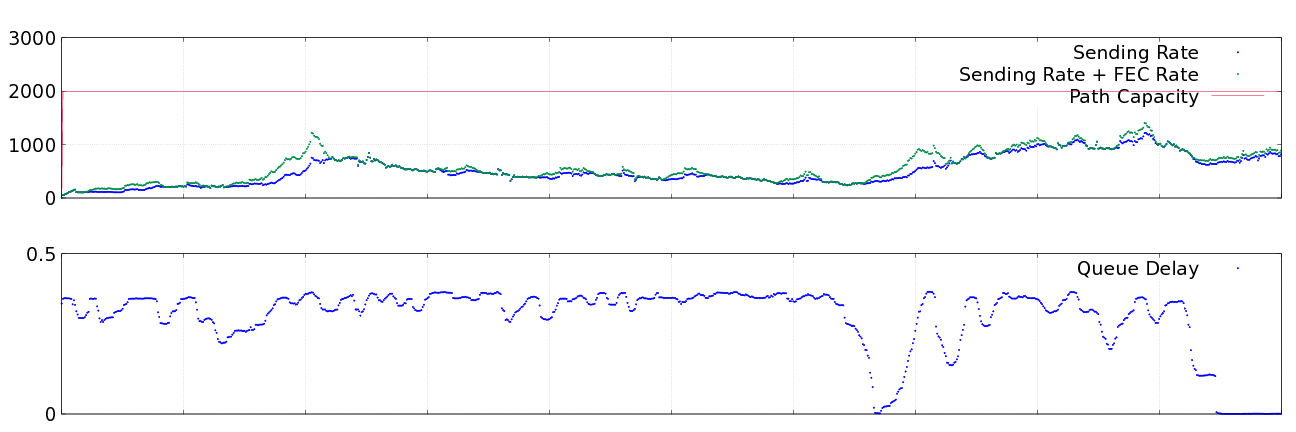

Figure 1. fractal 1 50ms 0ms


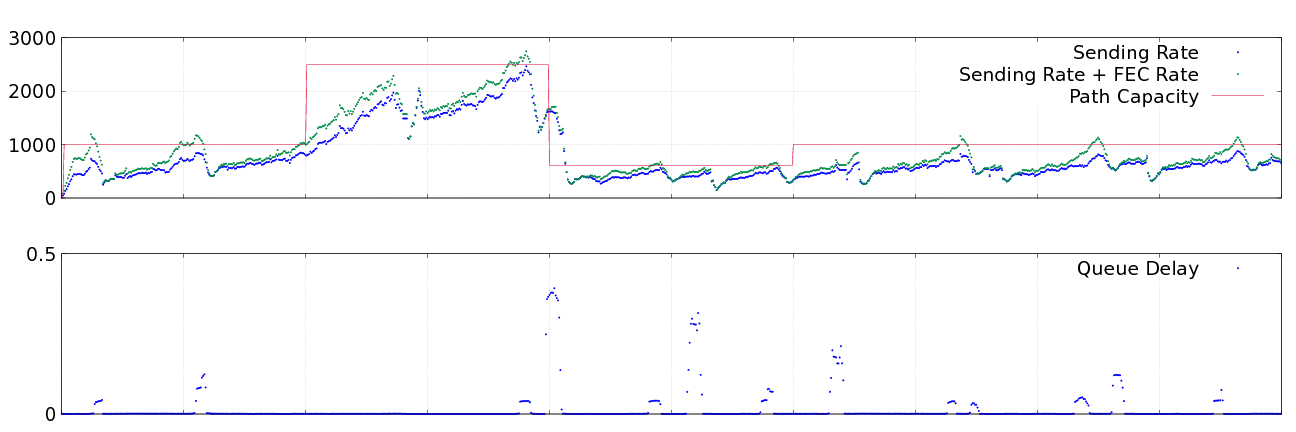

Figure 2. fractal 2 50ms 0ms


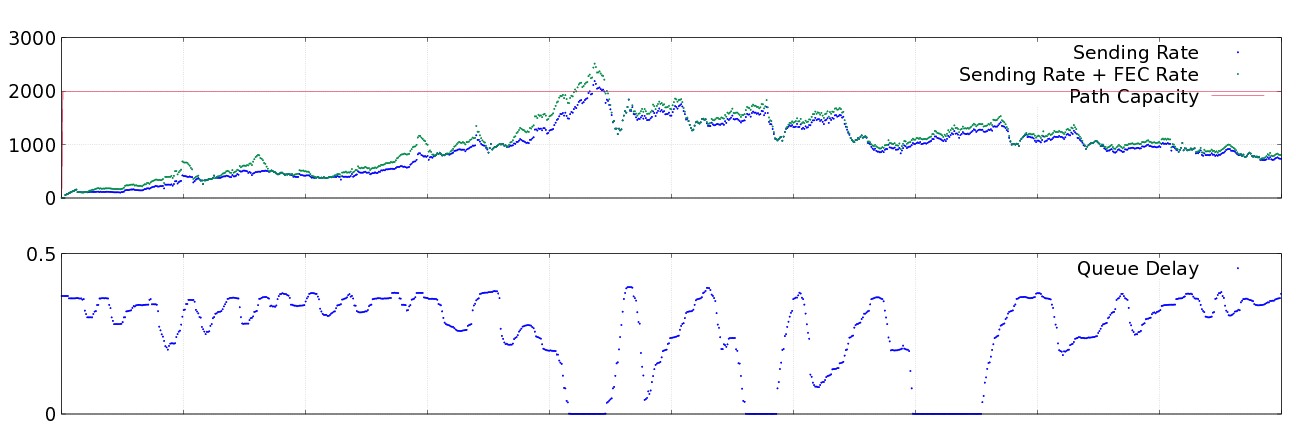

Figure 3. fractal 3 50ms 0ms


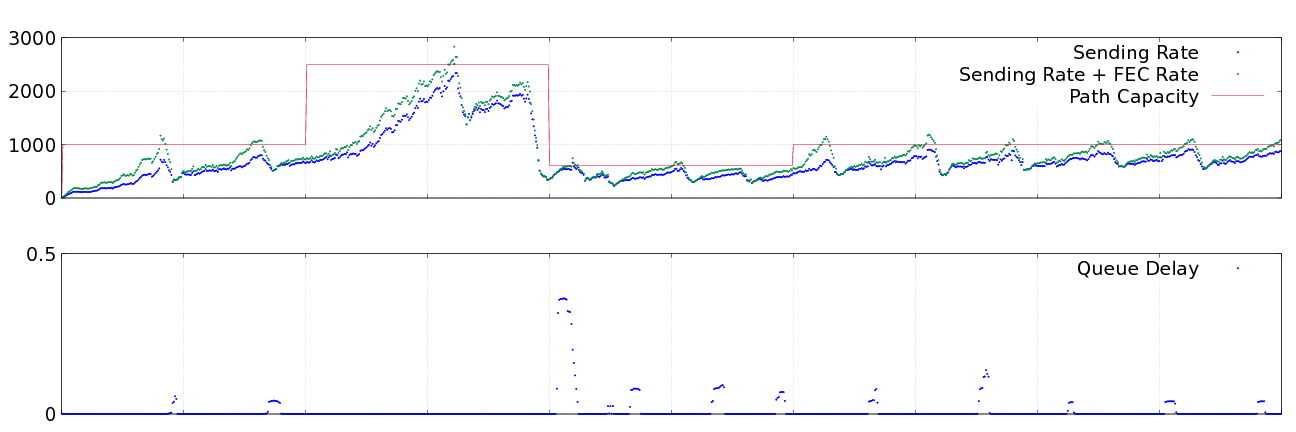

Figure 4. fractal 4 50ms 0ms


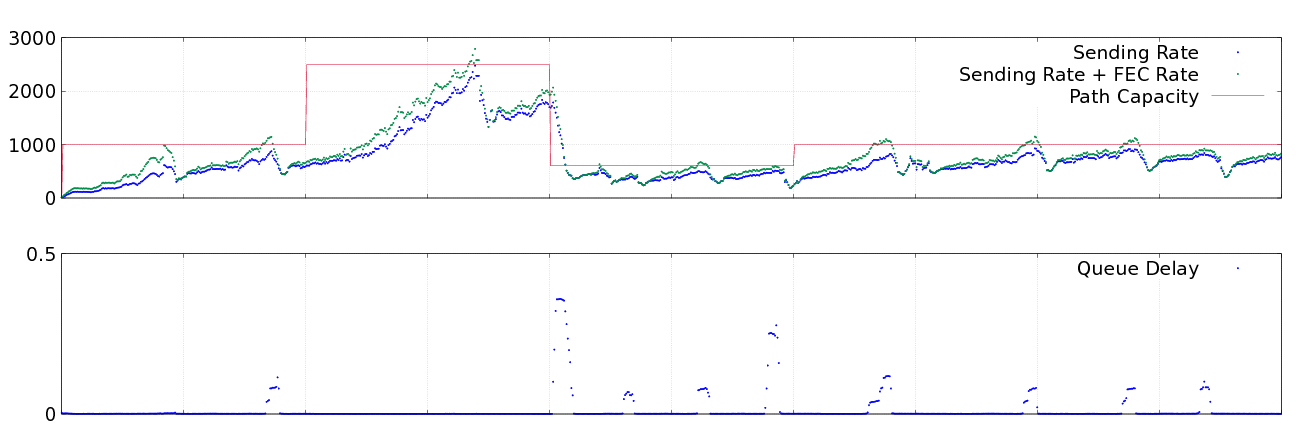

Figure 5. fractal 5 50ms 0ms


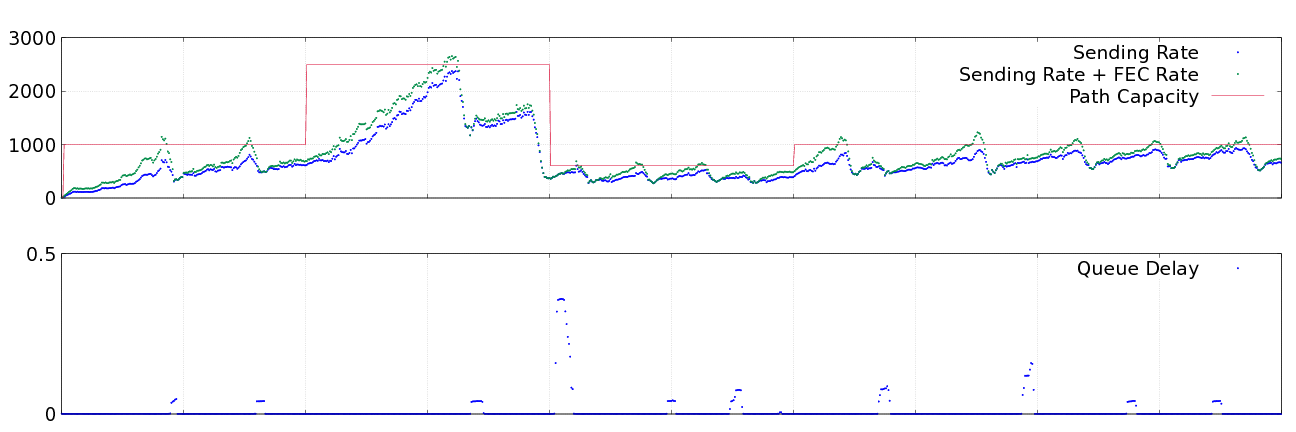

Figure 6. fractal 6 50ms 0ms


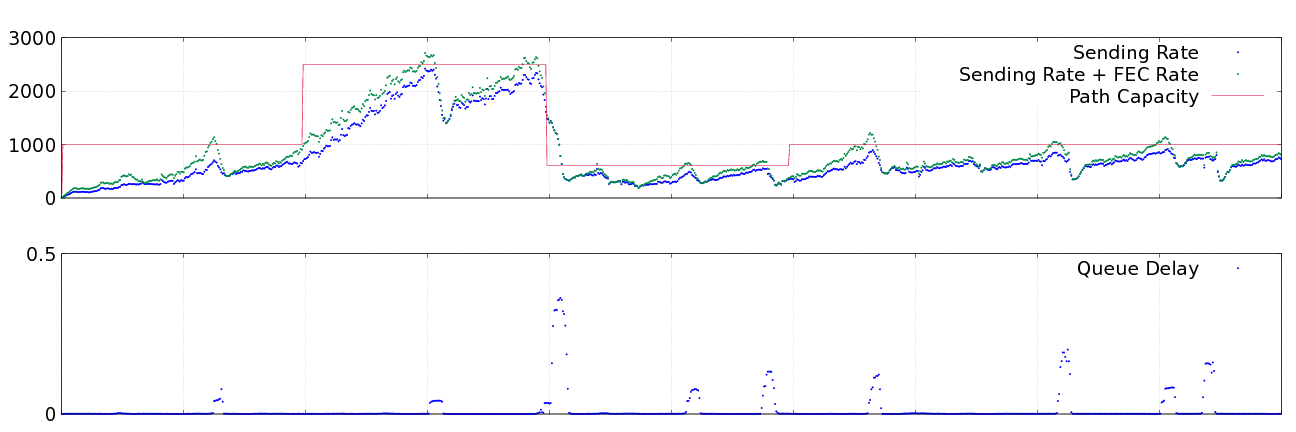

Figure 7. fractal 7 50ms 0ms


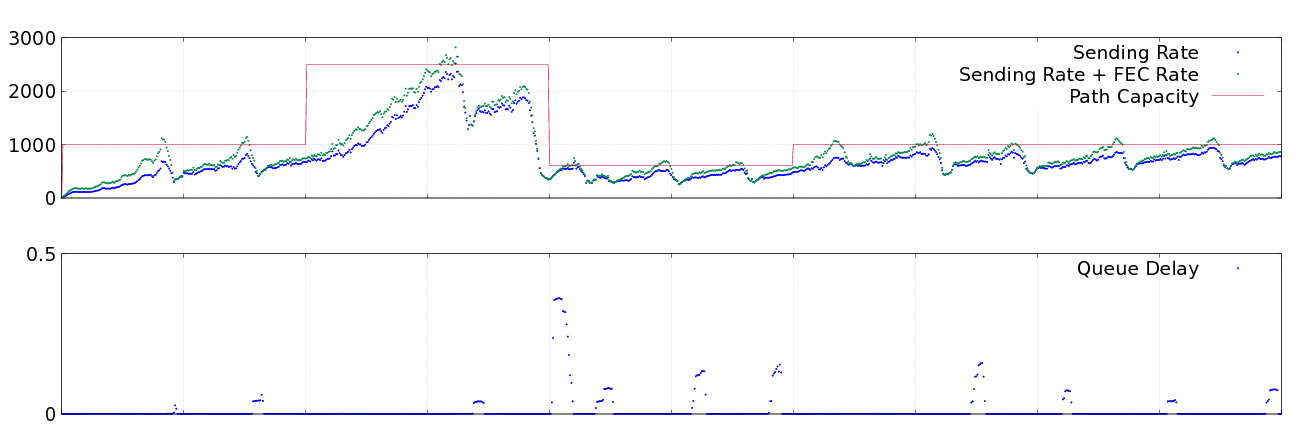

Figure 8. fractal 8 50ms 0ms


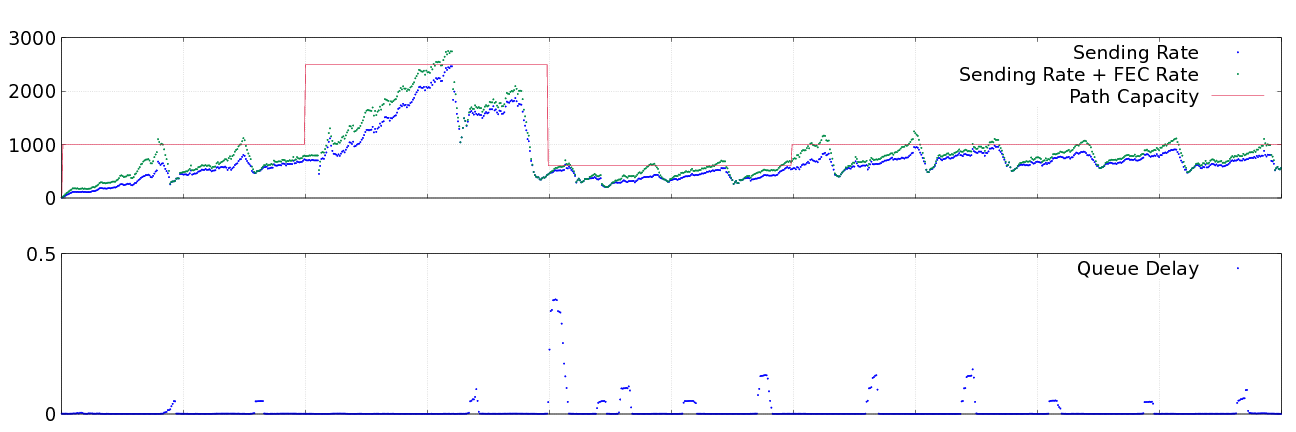

Figure 9. fractal 9 50ms 0ms


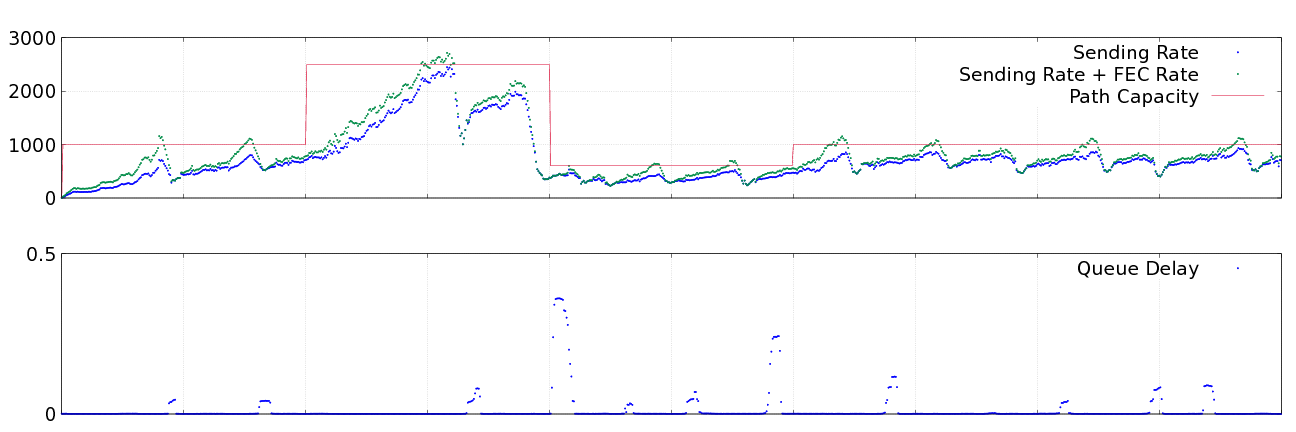

Figure 10. fractal 10 50ms 0ms


In [63]:
from wand.image import Image as WImage
from io import BytesIO
from IPython.display import display, Image

test      = "rmcat1"
# test      = "rmcat2"
# test      = "rmcat3"
# test      = "rmcat4"
# test      = "rmcat5"
# test      = "rmcat6"
# test      = "rmcat7"
algorithm = "fractal"
# algorithm = "scream"
# owd       = "50x100x150ms"
owd       = "50ms"
# owd       = "100ms"
# owd       = "300ms"
jitter    = "0ms"
 

for counter in range(1, 11):
    try:
        directory = test + "/" + '_'.join([algorithm, str(counter), owd, jitter])
        pdf       = '_'.join([test, algorithm, owd, jitter]) + ".pdf"
        img       = WImage(filename='../saves/' + directory +'/' + pdf)
        display(img)
        print("Figure " + str(counter) + ". " + ' '.join([algorithm, str(counter), owd, jitter]))
    except:
        print("ERROR happened at " + ' '.join([algorithm, str(counter), owd, jitter]))
        continue
